# 说明
https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html

1. scipy.integrate给定输入即初值条件，将终止时刻的状态作为输出。
2. scipy.integrate提供了数值积分器，但对于神经网络的反向传播需要的自动微分无法实现。
3. torchdiffeq实现了自动微分
4. 伴随模式：O(1) memory

1.  scipy.integrate.solve_ivp(fun, t_span, y0, method='RK45', t_eval=None, dense_output=False, events=None, vectorized=False, **options)
   
2. scipy.integrate.odeint(func, y0, t, args=(), Dfun=None, col_deriv=0, full_output=0, ml=None, mu=None, rtol=None, atol=None, tcrit=None, h0=0.0, hmax=0.0, hmin=0.0, ixpr=0, mxstep=0, mxhnil=0, mxordn=12, mxords=5, printmessg=0, tfirst=False)


## 引入包

In [8]:
import matplotlib.pyplot as plt
from numpy import sin, cos, linspace, pi
from scipy.integrate import odeint, solve_bvp, solve_ivp
import numpy as np
import torchdiffeq 
import torch

## 求解一阶ODE

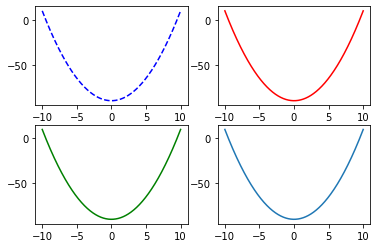

In [11]:
def f1(y,t):
    '''
    dy/dt = func(y, t, ...)
    '''
    return 2 * t

def f2(t,y):
    '''
    odeint引进tfirst参数，其值为True时，func的参数顺序为 t,y
    '''
    return 2 * t

def solve_first_order_ode():
    '''
    求解一阶ODE
    '''
    t1 = linspace(-10,10,1000)
    y0 = [10] # 初值是array类型
    
    y1 = odeint(f1, y0, t1)
    y2 = odeint(f2, y0, t1, tfirst=True) 
    y3 = solve_ivp(f2, (-10.0,10.0), y0, method='LSODA', t_eval=t1)   # 注意参数t_span和t_eval的赋值
    y4 = torchdiffeq.odeint(f2, torch.tensor(y0,dtype=torch.float32), torch.tensor(t1))
    
    plt.subplot(221)
    plt.plot(t1, y1, 'b--', label='scipy odeint')
    plt.subplot(222)
    plt.plot(t1, y2, 'r-', label='odeint with tfirst')
    plt.subplot(223)
    plt.plot(y3.t, y3.y[0], 'g', label='solve_ivp')
    plt.subplot(224)
    plt.plot(t1, y4.numpy(), label='torchdiffeq odeint')
    plt.show()
    
solve_first_order_ode()


## 求解二阶ODE

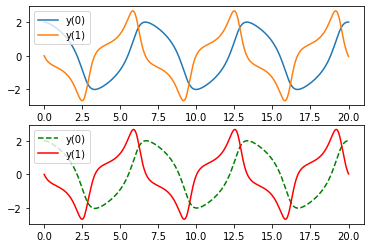

In [12]:
def fvdp1(t,y):
    '''
    把y看成一个向量，y = [dy0,dy1,dy2,...]分别表示y的n阶导，
    那么y[0]就是需要求解的函数，y[1]表示一阶导，y[2]表示二阶导，以此类推
    '''
    dy1 = y[1]      # y[1]=dy/dt，一阶导
    dy2 = (1 - y[0]**2) * y[1] - y[0] # y[0]是最初始，也就是需要求解的函数
    # 注意返回的顺序是[一阶导， 二阶导]，这就形成了一阶微分方程组
    return [dy1, dy2] 

# 或者下面写法更加简单
def fvdp2(t,y):
    '''
    把y看成一个向量，y = [dy0,dy1,dy2,...]分别表示y的n阶导，
    对于二阶微分方程，肯定是由0阶和1阶函数组合而成的，
    所以下面把y看成向量的话，y0表示最初始的函数，即要求解的函数，
    y1表示一阶导，对于高阶微分方程也可以依此类推
    '''
    y0, y1 = y   # y0是需要求解的函数，y1是一阶导
    # 注意返回的顺序是[一阶导， 二阶导]，这就形成了一阶微分方程组
    dydt = [y1, (1-y0**2)*y1-y0] 
    return dydt

def solve_second_order_ode():
    '''
    求解二阶ODE
    '''
    t2 = linspace(0,20,1000)
    tspan = (0.0, 20.0)
    y0 = [2.0, 0.0] # 初值条件
    # 初值[2,0]表示y(0)=2,y'(0)=0
    # 返回y，其中y[:,0]是y[0]的值，就是最终解，y[:,1]是y'(x)的值
    y = odeint(fvdp1, y0, t2, tfirst=True)
    y_ = solve_ivp(fvdp2, t_span=tspan, y0=y0, t_eval=t2)
    
    plt.subplot(211)
    l1, = plt.plot(t2, y[:,0], label='y(0)')
    l2, = plt.plot(t2, y[:,1], label='y(1)')
    plt.legend(handles=[l1,l2], loc=2)
    
    plt.subplot(212)
    l3, = plt.plot(y_.t, y_.y[0,:],'g--',label='y(0)')
    l4, = plt.plot(y_.t, y_.y[1,:],'r-',label='y(1)')
    plt.legend(handles=[l3,l4], loc=2)
    
    plt.show()

solve_second_order_ode()


## 求解高阶ODE

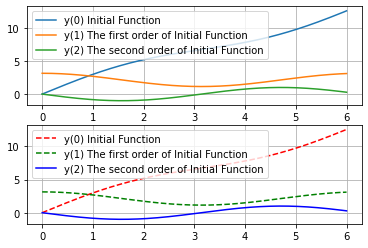

In [13]:
def f(t,y):
    dy1 = y[1]
    dy2 = y[2]
    dy3 = -np.cos(t)
    return [dy1,dy2,dy3]


def solve_high_order_ode():
    '''
    求解高阶ODE
    '''
    t = np.linspace(0,6,1000)
    tspan = (0.0, 6.0)
    y0 = [0.0, pi, 0.0]
    # 初值[0,1，0]表示y(0)=0,y’(0)=1，y''(0)=0
    # 返回y， 其中y[:,0]是y[0]的值 ，就是最终解 ，y[:,1]是y’(x)的值
    y = odeint(f, y0, t, tfirst=True)
    y_ = solve_ivp(f,t_span=tspan, y0=y0, t_eval=t)
    
    plt.subplot(211)
    l1, = plt.plot(t, y[:,0], label='y(0) Initial Function')
    l2, = plt.plot(t, y[:,1], label='y(1) The first order of Initial Function')
    l3, = plt.plot(t, y[:,2], label='y(2) The second order of Initial Function')
    plt.legend(handles=[l1,l2,l3], loc=2)
    plt.grid('on')
    
    plt.subplot(212)
    l4, = plt.plot(y_.t, y_.y[0,:], 'r--', label='y(0) Initial Function')
    l5,=  plt.plot(y_.t, y_.y[1,:], 'g--', label='y(1) The first order of Initial Function')
    l6, = plt.plot(y_.t, y_.y[2,:], 'b-', label='y(2) The second order of Initial Function')
    plt.legend(handles=[l4,l5,l6], loc=2) 
    plt.grid('on')
    
    plt.show()
    
solve_high_order_ode()


# 问题
已知一物体在平面运动中x，y方向的速度，绘制其运动轨迹。    
解决思路    
（1）已知dx/dt=f(t), dy/dt=g(t)     
（2）使用odeint求解微分方程组，得到x,y方向的位置     
（3）根据x,y位置绘制轨迹

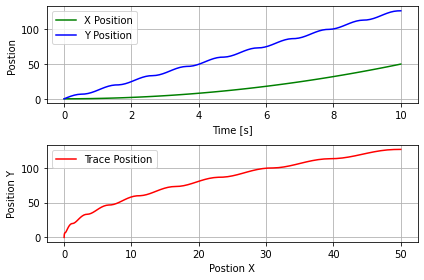

In [14]:
from pylab import *
from scipy.integrate import odeint
import warnings
warnings.filterwarnings('ignore')

def model(z,t):
    '''
    ODE in x,y direction
    '''
    dxdt = t # x轴运动：dx/dt=f(t)
    dydt = abs(20*cos(3*t)) # y轴运动轨迹：dy/dt=g(t)

    return [dxdt, dydt]

y0 = [0,0]
t = linspace(0,10,100)
z = odeint(model,y0,t)

x_pos = z[:,0] # position in x direction
y_pos = z[:,1] # position in y direction
pos = sqrt(x_pos**2+y_pos**2)

def show_res():

    plt.subplot(211)
    plt.plot(t,x_pos,'g-', label='X Position')
    plt.plot(t,y_pos,'b-', label='Y Position', )
    plt.legend()
    plt.xlabel('Time [s]')
    plt.ylabel('Postion')
    plt.grid()

    plt.subplot(212)
    plt.plot(x_pos,y_pos,'r-',label='Trace Position')
    plt.xlabel('Postion X')
    plt.ylabel('Position Y')
    plt.grid()

    plt.legend()
    plt.tight_layout()
    plt.show()

show_res()